# Climate Analysis

## Reflect Tables into SQLAlchemy ORM

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd

import datetime as dt
from dateutil.relativedelta import relativedelta

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
AllMeasurementData = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date > "2016-08-31").\
    order_by(Measurement.date.desc()).limit(10).all()
for data in AllMeasurementData:
    print(data)

(2724, 'USC00519397', '2017-08-23', 0.0, 81.0)
(7635, 'USC00514830', '2017-08-23', 0.0, 82.0)
(12187, 'USC00519523', '2017-08-23', 0.08, 82.0)
(19550, 'USC00516128', '2017-08-23', 0.45, 76.0)
(2723, 'USC00519397', '2017-08-22', 0.0, 82.0)
(12186, 'USC00519523', '2017-08-22', 0.0, 82.0)
(19549, 'USC00516128', '2017-08-22', 0.5, 76.0)
(2722, 'USC00519397', '2017-08-21', 0.0, 81.0)
(7634, 'USC00514830', '2017-08-21', 0.02, 79.0)
(12185, 'USC00519523', '2017-08-21', None, 82.0)


## Precipitation Analysis

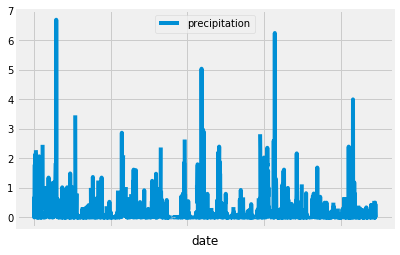

In [71]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).all()
last_date = last_date[0][0]
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d').date()
year_before_date = ((last_date - relativedelta(years = 1)).strftime('%Y-%m-%d'))

# Perform a query to retrieve the data and precipitation values
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_before_date).order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns = ["date", "precipitation"])

# Sort the dataframe by date
df.sort_values(by = ["date"], ascending = True, inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
chart = df.plot(x = "date", y = "precipitation")
plt.xlabel("date")
chart.legend(loc='upper center')
plt.show()

## Station Analysis

In [72]:
# Design a query to calculate the total number of stations.
session.query(Station.station).count()

9

In [79]:
# Design a query to find the most active stations.
stations = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

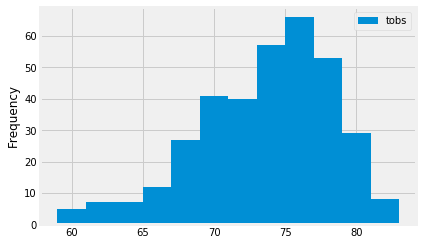

In [98]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
observation_data = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()

# Filter by the station with the highest number of observations.
station = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == observation_data[0]).filter(Measurement.date >= year_before_date).all()

# Plot the results as a histogram with bins=12.
station_df = pd.DataFrame(station, columns = ["station", "tobs"])
station_df.hist(column="tobs", bins = 12)
plt.ylabel("Frequency")
plt.legend(["tobs"], loc = "upper right")
plt.title("")
plt.show()